# Dataset download

In [1]:
project_name = '06b-anime-dcgan'

In [2]:
import torch

torch.cuda.is_available()

True

In [3]:
import os

DATA_DIR = '/kaggle/input/animefacedataset'
os.listdir(DATA_DIR)

['images']

In [4]:
image_size = 64
batch_size = 128
stats = ((.5,.5,.5), (.5,.5,.5))

In [5]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms as T

train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [6]:
import torch
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
%matplotlib inline

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))
    plt.show()

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

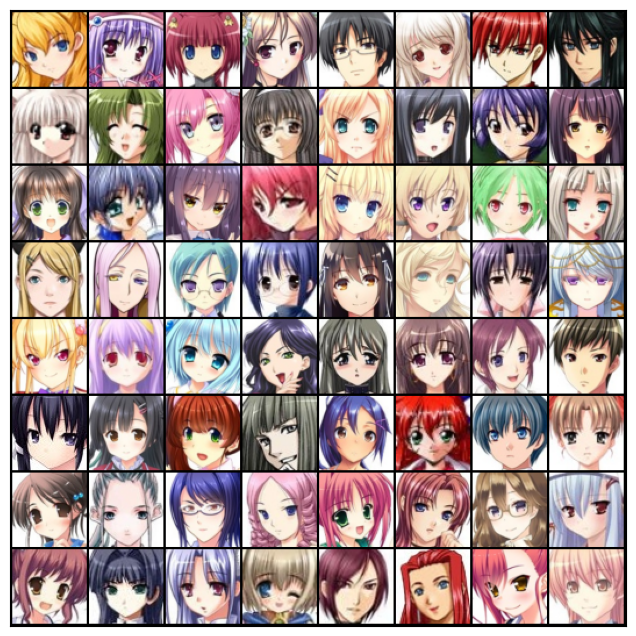

In [7]:
show_batch(train_dl)

In [8]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cuda')

In [10]:
train_dl = DeviceDataLoader(train_dl, device)
train_dl

# Define network
### Discriminator

In [11]:
from torch import nn

discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(.2, inplace=True),
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(.2, inplace=True),
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(.2, inplace=True),
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(.2, inplace=True),
    
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

discriminator

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

In [12]:
discriminator = to_device(discriminator, device)

# Generator

In [13]:
latent_size = 128

In [19]:
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out 512 x 4 x 4, cause of kernel_size and stride of 1
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out 256 x 8 x 8, cause of kernel_size and strid
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

generator

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

torch.Size([128, 128, 1, 1])
torch.Size([128, 3, 64, 64])


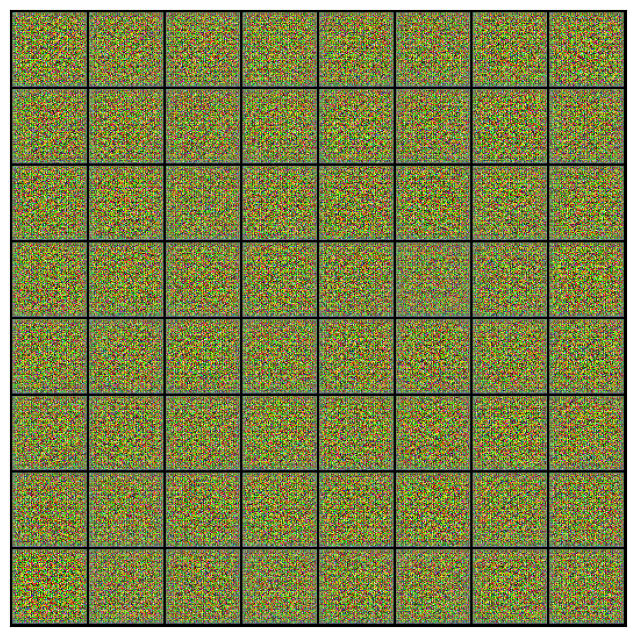

In [20]:
x_test = torch.randn(batch_size, latent_size, 1, 1)
print(x_test.shape)
fake_images = generator(x_test)
print(fake_images.shape)
show_images(fake_images)

In [21]:
generator = to_device(generator, device)

# Training
### Discriminator

In [22]:
from torch.nn import functional as F

def train_discriminator(real_images, opt_d):
    # reset gradient
    opt_d.zero_grad()

    # pass real image
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # generate fake image
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # pass fake images
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss

    # compute backprop
    loss.backward()

    # compute gradient
    opt_d.step()
    return loss.item(), real_score, fake_score

### Generator

In [23]:
def train_generator(opt_g):
    opt_g.zero_grad()

    # generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1 , device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # update weights
    loss.backward()
    opt_g.step()
    return loss.item()

In [37]:
from torchvision.utils import save_image

sample_dir = '/kaggle/working/generated'
os.makedirs(sample_dir, exist_ok=True)

In [38]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving:', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1,2,0))
        plt.show()

Saving: generated-images-0000.png


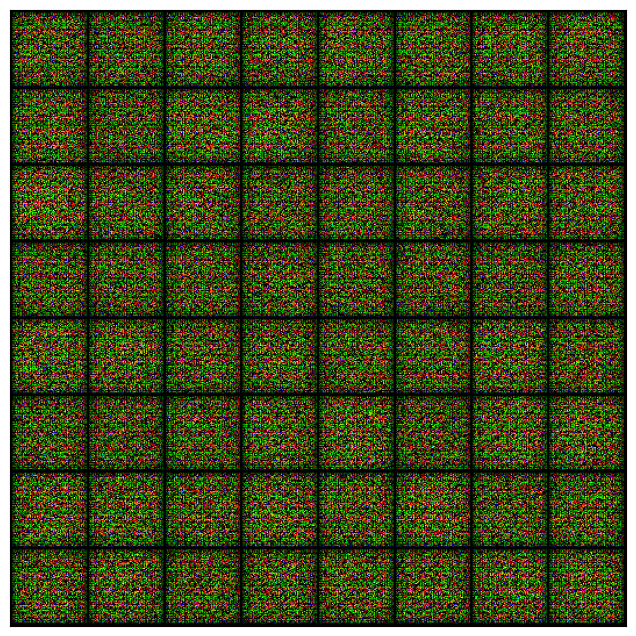

In [39]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)

### Full training loop

In [44]:
from tqdm.notebook import tqdm
from torch import optim

def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # losses and scores
    losses_g, losses_d = [], []
    real_scores, fake_scores = [], []

    # create optimizer
    opt_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(.5,.999))
    opt_g = optim.Adam(generator.parameters(), lr=lr, betas=(.5,.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # logging
        print(f'Epoch [{epoch+1}/{epochs}] - loss_g: {loss_g} - loss_d: {loss_d} - real_score: {real_score} - fake_score: {fake_score}')

        # save generated image
        save_samples(epoch+start_idx, fixed_latent, show=False)
    return losses_g, losses_d, real_scores, fake_scores

In [45]:
lr = 2e-4
epochs = 5

In [46]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/5] - loss_g: 2.7013843059539795 - loss_d: 0.5040028095245361 - real_score: 0.6953942179679871 - fake_score: 0.04676827788352966
Saving: generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/5] - loss_g: 3.6240649223327637 - loss_d: 0.26042887568473816 - real_score: 0.8507887721061707 - fake_score: 0.06696385145187378
Saving: generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/5] - loss_g: 4.731043815612793 - loss_d: 0.290505051612854 - real_score: 0.8696917295455933 - fake_score: 0.1204492449760437
Saving: generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/5] - loss_g: 4.431116580963135 - loss_d: 0.11332222819328308 - real_score: 0.9133239388465881 - fake_score: 0.014407468028366566
Saving: generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/5] - loss_g: 5.418368816375732 - loss_d: 0.24304428696632385 - real_score: 0.8741884231567383 - fake_score: 0.08072720468044281
Saving: generated-images-0005.png


In [47]:
import cv2

vid_name = 'gans_training.avi'
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_name, cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [49]:
losses_g, losses_d, real_scores, fake_scores = history

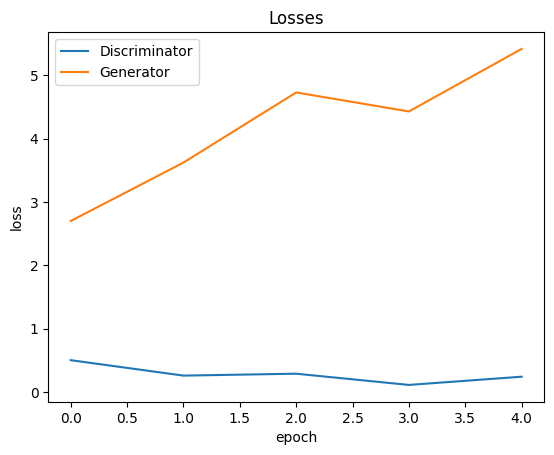

In [50]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')
plt.show()